# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [116]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from sklearn.model_selection import StratifiedKFold


from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [117]:
# load in the data
azdias = pd.read_csv('azdias.csv', sep=';')
customers = pd.read_csv('customers.csv', sep=';')
attribute_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)
attribute_desc = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header=1)

C:\Users\e079666\AppData\Local\Temp\ipykernel_10012\55498600.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('azdias.csv', sep=';')
C:\Users\e079666\AppData\Local\Temp\ipykernel_10012\55498600.py:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('customers.csv', sep=';')


In [118]:
# Find what columns are not in General Population but are in Customers data

set2 = set(azdias.columns.tolist())
set1 = set(customers.columns.tolist())
uncommon = set1.symmetric_difference(set2)
print(uncommon)

{'ONLINE_PURCHASE', 'PRODUCT_GROUP', 'CUSTOMER_GROUP'}


In [119]:
#Drop columns not in General Population data but in Customers data

customers = customers.drop(uncommon, axis = 1)

In [120]:
# Shape and Clean Attribute data to be used later

attribute_desc.loc[0, 'Information level'] = 'Person'
attribute_values.drop("Unnamed: 0", axis = 1, inplace = True)
attribute_desc.drop("Unnamed: 0", axis = 1, inplace = True)
attribute_desc['Information level'] = attribute_desc['Information level'].ffill()
attribute_desc['Attribute'] = attribute_desc['Attribute'].str.replace("_ ", "_").str.split()
attribute_desc = attribute_desc.explode('Attribute')
attribute_values['Attribute'] = attribute_values['Attribute'].ffill()
attribute_values['Description'] = attribute_values['Description'].ffill()


In [121]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [122]:
print(azdias.shape)

(891221, 366)


In [123]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,137392.000000,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,2.429508,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,1.148821,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,2.000000,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,3.000000,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [124]:
print(customers.shape)

(191652, 366)


# Data Processing / Cleaning

## Replacing Nan and Unknown Values

In [125]:
# Create Dictionary to map unknown values as nan

unknown_dict = {}

for i, row in attribute_values.iterrows():
    if "unknown" in str(row['Meaning']).lower():
        unknown_dict[row['Attribute']] = [int(num) for num in str(row['Value']).split(', ')]

unknown_dict['AGER_TYP'].append(0)
unknown_dict['AGER_TYP'] = list(set(unknown_dict['AGER_TYP']))
unknown_dict['ALTERSKATEGORIE_GROB'].append(9)
unknown_dict['ALTERSKATEGORIE_GROB'] = list(set(unknown_dict['ALTERSKATEGORIE_GROB']))

In [126]:
def replace_unknown_w_nan(df, unknown_dict):
    
    """
    Replaces unknown value encodings with nan values
    Parameters: df - demographic dataframe, unknown_dict - dictionary of unknown values
    Output: None
    """
    
    for k, v in unknown_dict.items():
        if k in df.columns:
            for i in range(len(v)):
                df.loc[df[k] == v[i], k] = np.nan

In [127]:
# these repersent birth years that are equal to zero and should be nan
incorrect_values = {'KBA05_MODTEMP': [6.0], 'LP_FAMILIE_FEIN': [0.0], 'LP_FAMILIE_GROB': [0.0],
                            'LP_LEBENSPHASE_FEIN': [0.0], 'LP_LEBENSPHASE_GROB': [0.0], 'ORTSGR_KLS9': [0.0], 'GEBURTSJAHR': [0]}

In [128]:
# Map nan on unknown values

print(azdias.isnull().sum().sum())
replace_unknown_w_nan(azdias, unknown_dict)
replace_unknown_w_nan(customers, unknown_dict)
print(azdias.isnull().sum().sum())
replace_unknown_w_nan(azdias, incorrect_values)
replace_unknown_w_nan(customers, incorrect_values)
print(azdias.isnull().sum().sum())

33492923
37098738
37829035


## Dropping Columns and Rows

### Drop Columns

In [129]:
def drop_useless_cols(df):
    '''
    Function deletes columns with no useful info
    
    Parameters:
    df - demographic dataframe.
    
    Output:
    df - demographic dataframe with removed columns.
    '''
    columns = ['LNR', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'D19_LETZTER_KAUF_BRANCHE']
    
    try:
        df.drop(columns = columns, inplace = True)
    
    except KeyError:
        pass
        
    return df, columns
    
azdias, columns = drop_useless_cols(azdias)
customers, columns = drop_useless_cols(customers)

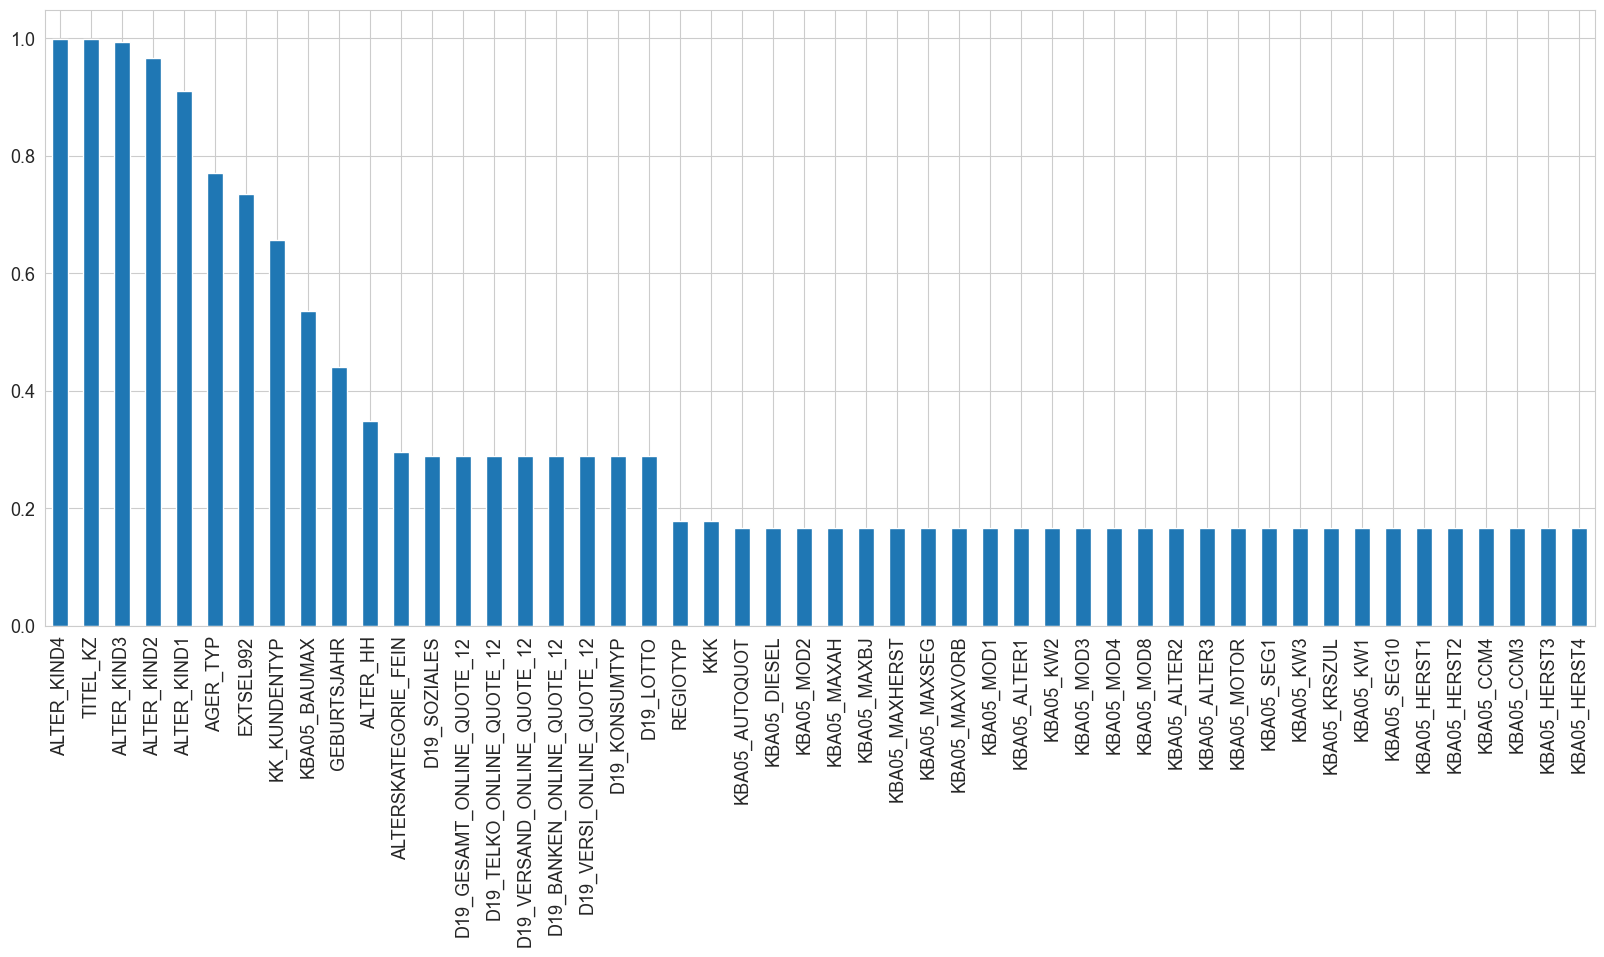

In [130]:
# Plot columns with most missing data in descending order

azdias_null_percent_cols = azdias.isnull().mean().sort_values(ascending = False)
azdias_null_percent_cols[:50].plot(kind = 'bar',  figsize= (20,8), fontsize = 13)
plt.show()

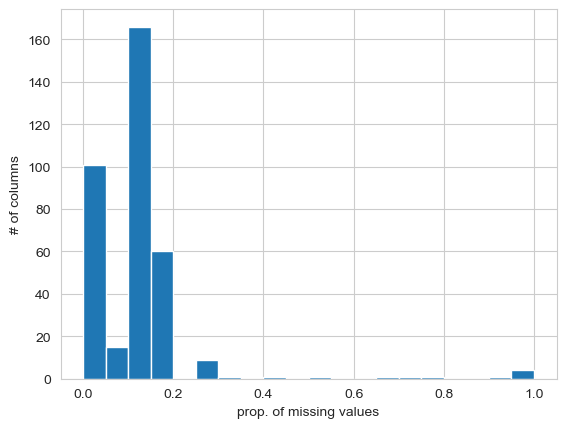

In [131]:
# Plot histogram to see distrubution proprotion of columns missing 

column_nans = azdias.isnull().mean()
plt.hist(column_nans, bins = np.arange(0,1+.05,.05))
plt.ylabel('# of columns')
plt.xlabel('prop. of missing values')
plt.show()

In [132]:
def drop_columns_missing_data(df, threshold):
    
    """
    Function drops columns above certain threshold percent of missing data
    Parameters: df - demographic data, threshold - data above certain level of missing data
    Output: df - demographic data without columns with high amounts of missing data
    """
    
    cols_drop = df.columns[df.isnull().mean() > threshold].tolist()
    print(f'There are {len(cols_drop)} columns missing more than {threshold * 100}% of data')
    df = df.drop(cols_drop, axis = 1)
    print(f'These columns were dropped {cols_drop}')
    return df, cols_drop
    

In [133]:
# Drop columns missing large amounts of data when compared to the rest of the data

azdias, cols_drop = drop_columns_missing_data(azdias, threshold = .30)
customers = customers.drop(cols_drop, axis = 1)

There are 11 columns missing more than 30.0% of data
These columns were dropped ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']


In [134]:
print(customers.shape)
print(azdias.shape)

(191652, 351)
(891221, 351)


### Drop Rows

In [135]:
missing_row_percent = azdias.isnull().mean(axis = 1) * 100

In [136]:
cum_sum_missing_rows = (azdias.isnull().sum(axis=1).value_counts().sort_index().cumsum()/azdias.isnull().sum(axis=1).shape[0]*100)

In [137]:
cum_sum_missing_rows[:20]

0     47.598856
1     54.937103
2     57.464759
3     59.148180
4     60.444716
5     60.670025
6     62.331453
7     63.137650
8     69.968728
9     78.005455
10    78.503648
11    79.028771
12    79.583964
13    79.766186
14    80.353582
15    80.896433
16    81.313165
17    82.035320
18    82.087271
19    82.155380
dtype: float64

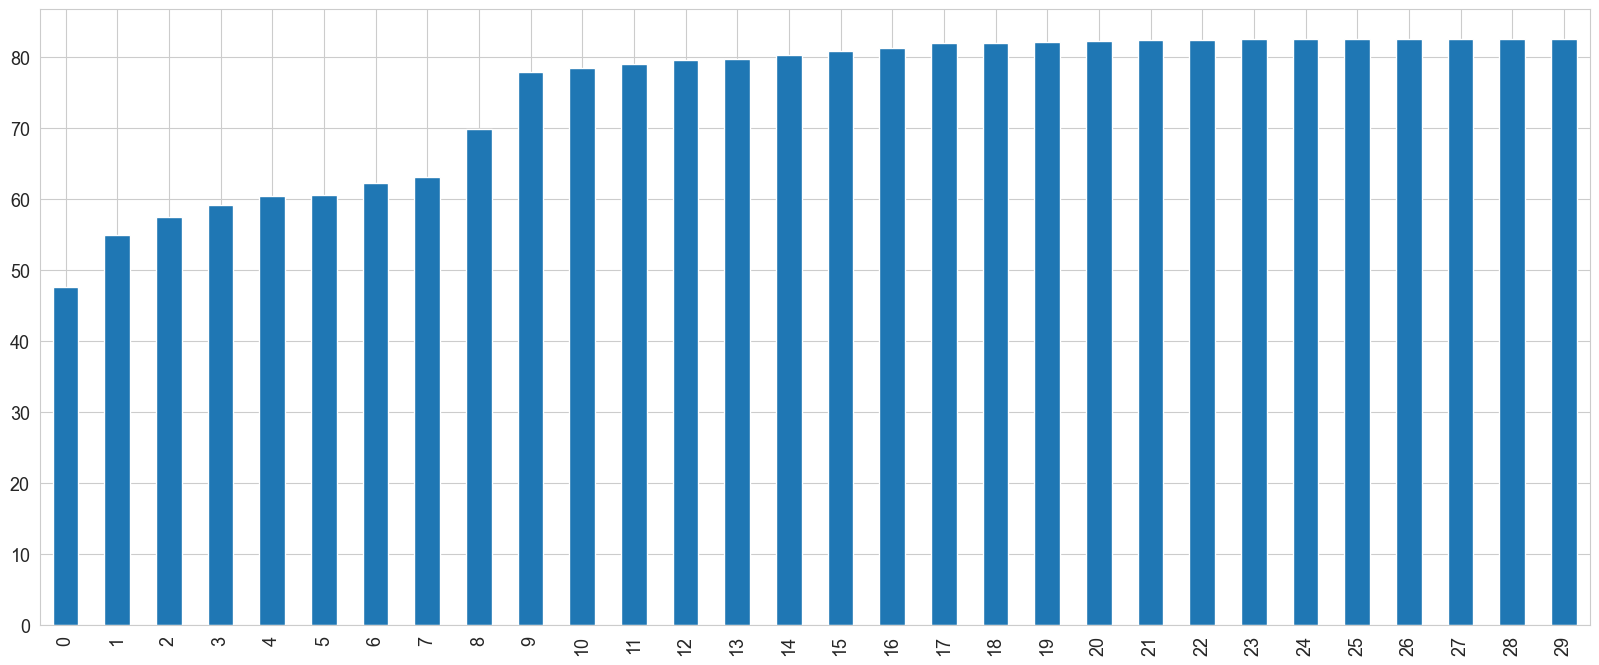

In [138]:
#Plot cumlative sum of rows to see where number of rows missing trails off 

cum_sum_missing_rows[:30].plot(kind = 'bar',  figsize= (20,8), fontsize = 13)
plt.show()

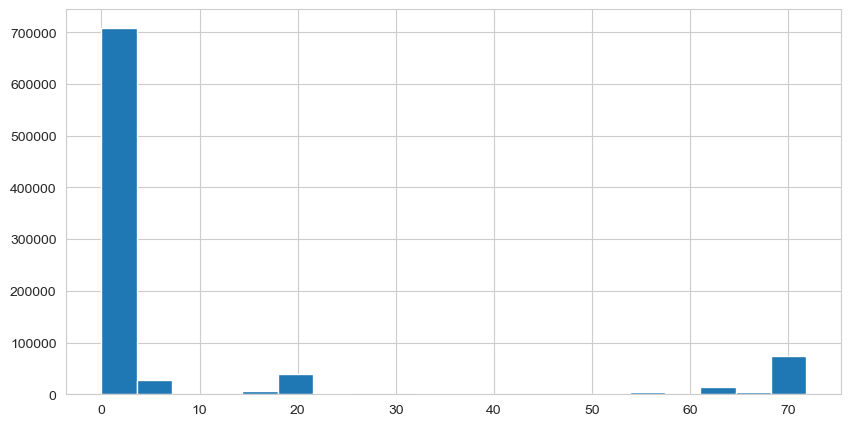

In [139]:
# Plot to see the distrubution of missing values in rows and where most of the values lie when compared to the rest of data

plt.figure(figsize = (10, 5))
plt.hist(missing_row_percent, bins = 20)
plt.show()

the number of missing rows appears it level off around 50%

In [140]:
# Filters out ROWS missing more than 50% data

azdias = azdias[azdias.isnull().sum(axis = 1)/azdias.shape[1] < .5]
customers = customers[customers.isnull().sum(axis = 1)/customers.shape[1] < .5]

In [141]:
print(azdias.shape)
print(customers.shape)

(791252, 351)
(140866, 351)


## Categorical Variables

In [142]:
def fix_mixed_types(df):
    
    '''
    This function is created for formating values in columns CAMEO_DEU/G_2015 and CAMEO_INTL_2015.
    Parameters df: demographics dataframe
    Output df : cleaned transformed dataframe
    '''

    cols_nan = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015']
    cols_dtype = ['CAMEO_DEUG_2015']
    
    if set(cols_nan).issubset(df.columns):
        df[cols_nan] = df[cols_nan].replace({'X': np.nan, 'XX': np.nan})
        df[cols_dtype] = df[cols_dtype].astype(float)

    return df

In [143]:
# Map mixed data types with old values to nan

azdias = fix_mixed_types(azdias)
customers = fix_mixed_types(customers)

In [144]:
print(azdias.shape)
print(customers.shape)

(791252, 351)
(140866, 351)


## Feature Engineering

In [145]:
def feature_engineering(df):
    
    """
    Function is used to drop related columns and map new columns for over categorized data
    
    Parameters:
    df - demographic data
    
    Output:
    df - featured engineered demographic data with removed redundant columns
    """
    
    cameo_family_type = {
        11:'Pre-Family Couples & Singles',
        12:'Young Couples With Children',
        13:'Families With School Age Children',
        14:'Older Families &  Mature Couples',
        15:'Elders In Retirement',
        21:'Pre-Family Couples & Singles',
        22:'Young Couples With Children',
        23:'Families With School Age Children',
        24:'Older Families &  Mature Couples',
        25:'Elders In Retirement',
        31:'Pre-Family Couples & Singles',
        32:'Young Couples With Children',
        33:'Families With School Age Children',
        34:'Older Families &  Mature Couples',
        35:'Elders In Retirement',
        41:'Pre-Family Couples & Singles',
        42:'Young Couples With Children',
        43:'Families With School Age Children',
        44:'Older Families &  Mature Couples',
        45:'Elders In Retirement',
        51:'Pre-Family Couples & Singles',
        52:'Young Couples With Children',
        53:'Families With School Age Children',
        54:'Older Families &  Mature Couples',
        55:'Elders In Retirement',
    }
    
    cameo_wealth_type = {
        11:'Wealthy', 12:'Wealthy',13:'Wealthy', 14:'Wealthy', 15:'Wealthy', 
        21:'Prosperous', 22:'Prosperous', 23:'Prosperous', 24:'Prosperous', 25:'Prosperous',
        31:'Comfortable', 32:'Comfortable', 33:'Comfortable', 34:'Comfortable', 35:'Comfortable',
        41:'Less Affluent', 42:'Less Affluent', 43:'Less Affluent', 44:'Less Affluent', 45:'Less Affluent',
        51:'Poorer', 52:'Poorer', 53:'Poorer', 54:'Poorer', 55:'Poorer'
    }
    
    
    cameo_family_num = {"Pre-Family Couples & Singles": 1, "Young Couples With Children": 2, 
                        "Families With School Age Children":3, "Older Families &  Mature Couples": 4, "Elders In Retirement": 5}
    
    cameo_wealth_num = {"Wealthy": 1, "Prosperous" : 2, "Comfortable": 3, "Less Affluent": 4, "Poorer": 5}

    
    df['WEALTH_CAMEO_INTL'] = df['CAMEO_INTL_2015'].map(cameo_wealth_type).map(cameo_wealth_num)
    df['LIFE_STAGE_CAMEO_INTL'] = df['CAMEO_INTL_2015'].map(cameo_family_type).map(cameo_family_num)


    df['DECADE'] = [4 if df['PRAEGENDE_JUGENDJAHRE'].iloc[i] in [1, 2] \
                          else 5 if df['PRAEGENDE_JUGENDJAHRE'].iloc[i] in [3, 4] \
                          else 6 if df['PRAEGENDE_JUGENDJAHRE'].iloc[i] in [5, 6, 7] \
                          else 7 if df['PRAEGENDE_JUGENDJAHRE'].iloc[i] in [8, 9] \
                          else 8 if df['PRAEGENDE_JUGENDJAHRE'].iloc[i] in [10, 11, 12, 13] \
                          else 9 if df['PRAEGENDE_JUGENDJAHRE'].iloc[i] in [14, 15] \
                          else np.nan for i in range(df.shape[0])]

    #movement -> 1: mainstream, 0: avantgarde
    df['MOVEMENT_MA'] = [0 if df['PRAEGENDE_JUGENDJAHRE'].iloc[i] in [1, 3, 5, 8, 10, 12, 14] \
                         else 1 if df['PRAEGENDE_JUGENDJAHRE'].iloc[i] in [2, 4, 6, 7, 9, 11, 13, 15] \
                       else np.nan for i in range(df.shape[0])]

    
    df['GEBAEUDETYP'] = ['Residential' if df['GEBAEUDETYP'].iloc[i] in [1,2] \
    else 'Mixed' if df['GEBAEUDETYP'].iloc[i] in [3,4,6,8] \
    else 'Commercial' if df['GEBAEUDETYP'].iloc[i] in [5,7] \
    else np.nan for i in range(df.shape[0])]
    
    building_num = {'Residential': 1, 'Mixed': 2, 'Commercial': 3}
    
    df['GEBAEUDETYP'] = df['GEBAEUDETYP'].map(building_num)
    
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 0, 'O': 1})
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].fillna(df['OST_WEST_KZ'].value_counts().index[0])
    
    # dropped 'CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE' because engineered now
    # dropped 'LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN' because redundant
    # dropped 'LP_FAMILIE_FEIN' and LP_STATUS_FEIN because did not need that low level granularity when marketing
    # dropped 'CAMEO_DEU_2015' because over categorized and super low granularity
    
    drop_columns = ['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE', 'LP_LEBENSPHASE_GROB', 
             'LP_LEBENSPHASE_FEIN', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015']
    
    df.drop(drop_columns, axis = 1, inplace = True)
    
    
    return df, drop_columns

    

In [146]:
# Apply Feature engineering to demographic data

azdias, columns = feature_engineering(azdias)
customers, columns = feature_engineering(customers)

In [147]:
print(azdias.shape)
print(customers.shape)

(791252, 348)
(140866, 348)


## Change Data Types

In [148]:
def attribute_ranges(df):
    """
    Parameters: None
    Output: dictionary of unique values from every column from attribute data set
    
    """
    attribute_dict = {}
    attribute_meaning = {}
    for i, row in attribute_values.iterrows():
        
        if row['Attribute'] in azdias.columns:
            
            if row['Attribute'] in attribute_dict :
                attribute_dict[row['Attribute']].append(row['Value'])
                attribute_meaning[row['Attribute']].append(row['Meaning'])
            else:
                attribute_dict[row['Attribute']] = [row['Value']]
                attribute_meaning[row['Attribute']] = [row['Meaning']]

    return attribute_dict, attribute_meaning

In [149]:
category_columns = ['CJT_GESAMTTYP', 'D19_KONSUMTYP',
 'FINANZTYP',
 'GEBAEUDETYP',
 'GFK_URLAUBERTYP',
 'HEALTH_TYP',
 'KBA05_MAXHERST',
 'NATIONALITAET_KZ',
 'RETOURTYP_BK_S',
 'SHOPPER_TYP',
 'WOHNLAGE',
 'ZABEOTYP', 'LP_FAMILIE_GROB',
  'OST_WEST_KZ', 'REGIOTYP', 'KBA05_SEG6', 
    'KBA05_MODTEMP', 'KBA05_HERSTTEMP', 'LP_STATUS_GROB', 'VERS_TYP', 'ANREDE_KZ', 'GREEN_AVANTGARDE']

In [150]:
def change_dtypes(df):
    
    """
    The function changes the data types of the demographic data
    
    Parameters: demographic data
    Output: demographic data with new columns
    
    """

    for col in df.columns:
        
        if col in category_columns:
            df[col] = df[col].astype('category')
            df[col] = df[col].fillna(df[col].value_counts().index[0])
            
            
        else:
            df[col] = pd.to_numeric(df[col], errors = 'coerce')
            median = df[col].median()
            df[col].fillna(median, inplace = True)
    
    return df

In [151]:
# Identify and change data types to categorical

azdias = change_dtypes(azdias)
customers = change_dtypes(customers)

## Correlation Analysis

In [152]:
def get_corr_matrix(df, method):
    
    """
    This function creates a correlation matrix.
    
    Parameters: df- demographic data, method - method to use to find correlations between features
    Output: corr - correlation matrix with correlation values
    
    """
    
    corr = df.corr(method = method).abs()
    return corr

In [153]:
def analyze_correlation(df, category_cols, method = 'pearson', corr_threshold = .7):
    
    """
    Function Removes heavyily correlated columns from the dataframe prior to ML modeling
    Parameter
    df - demographic df, category_cols - columns excluded from correlation analysis,
    method - correlation method used, corr_threshold - threshold level for highly correlated features
    
    Output: drop_columns - correlated columns dropped
        
    """
    ordinal_numeric_cols = list(set(df.columns).difference(set(category_cols)))
    df = df[ordinal_numeric_cols]
    corr = get_corr_matrix(df, method = method)
    upper_limit = corr.where(np.triu(np.ones(corr.shape), k = 1).astype(np.bool_))
    drop_columns = [col for col in upper_limit.columns if any(upper_limit[col] > corr_threshold)]

    return drop_columns, corr
    

In [154]:
# Drop columns that are heavily correlated from the data

drop_columns, corr = analyze_correlation(azdias, category_cols = category_columns)
azdias = azdias.drop(drop_columns, axis = 1)
customers = customers.drop(drop_columns, axis = 1)

In [155]:
print(azdias.shape)
print(customers.shape)

(791252, 259)
(140866, 259)


## Outliers

In [156]:
def attribute_ranges_outliers():
    """
    Parameters: None
    Output: dictionary of unique values from every column from attribute data set
    
    """
    attribute_dict = {}
    for i, row in attribute_values.iterrows():
            
        if row['Attribute'] in attribute_dict :
            attribute_dict[row['Attribute']].append(row['Value'])
        else:
            attribute_dict[row['Attribute']] = [row['Value']]

    return attribute_dict

def get_unique_values(df):
    '''
    Parameters - df: demographics dataframe
    Output - unique_value_dict: returns dictionary of dataframe column unique values (col ranges)
    '''
    unique_value_dict = {}
    attribute_range = attribute_ranges(df)[0]
    
    for col in df.columns:
        unique_value_dict[col] = df[col].unique()
    
    return unique_value_dict

def get_difference(dic):
    '''
    Parameters - dic: dictionary to compare to attribute range
    Output - outliers_dict: returns dictionary of values not in the attribute range
    '''
    
    outliers_dict = {}
    attribute_range = attribute_ranges_outliers()
    
    
    for k, v in dic.items():
        if k in attribute_range:
            outliers_dict[k] = [i for i in v if i not in attribute_range[k]]
            
    return outliers_dict



validation_dict = get_difference(get_unique_values(azdias))

In [157]:
# Find features where the ranges fall outside the attribute data ranges given

for key, value in validation_dict.items():
    if len(value) > 1 or (len(value) == 1 and "nan" not in str(value[0])):
        print(key, value)

ANZ_HAUSHALTE_AKTIV [11.0, 10.0, 1.0, 3.0, 5.0, 4.0, 6.0, 2.0, 9.0, 0.0, 14.0, 13.0, 8.0, 7.0, 44.0, 25.0, 36.0, 272.0, 33.0, 15.0, 12.0, 22.0, 21.0, 20.0, 23.0, 18.0, 27.0, 24.0, 31.0, 39.0, 16.0, 19.0, 30.0, 17.0, 29.0, 61.0, 54.0, 88.0, 49.0, 60.0, 38.0, 34.0, 35.0, 62.0, 26.0, 45.0, 42.0, 28.0, 77.0, 47.0, 50.0, 236.0, 137.0, 43.0, 52.0, 41.0, 76.0, 63.0, 32.0, 40.0, 37.0, 59.0, 53.0, 57.0, 118.0, 95.0, 78.0, 70.0, 46.0, 185.0, 73.0, 67.0, 154.0, 80.0, 102.0, 92.0, 126.0, 48.0, 94.0, 71.0, 66.0, 68.0, 81.0, 69.0, 121.0, 258.0, 58.0, 86.0, 124.0, 85.0, 90.0, 128.0, 51.0, 72.0, 64.0, 56.0, 83.0, 150.0, 259.0, 91.0, 160.0, 134.0, 169.0, 246.0, 82.0, 114.0, 183.0, 116.0, 74.0, 143.0, 99.0, 216.0, 98.0, 125.0, 112.0, 123.0, 55.0, 120.0, 75.0, 141.0, 103.0, 87.0, 89.0, 223.0, 93.0, 179.0, 135.0, 149.0, 97.0, 101.0, 110.0, 79.0, 111.0, 109.0, 65.0, 84.0, 367.0, 162.0, 195.0, 107.0, 119.0, 331.0, 122.0, 161.0, 157.0, 175.0, 177.0, 136.0, 104.0, 316.0, 127.0, 100.0, 180.0, 155.0, 133.0, 178

In [158]:
def remove_outliers(df, sub_df):
    
    """
    Function removes rows of outliers found in the sub dataframe columns 
    
    Parmeters: df - full demographic data, sub_df - demographic data where we suspect outliers
    
    Output: df - demographic data with removed outliers
    
    """
    
    lower = sub_df.quantile(0.25)
    upper = sub_df.quantile(0.75)
    IQR = upper - lower
    df = df[~((sub_df < (lower - 1.5 * IQR)) | (sub_df > (upper + 1.5 * IQR))).any(axis=1)]
    return df


In [160]:
# Remove outliers from the data that do not fall within the ranges in the attribute values data

azdias = remove_outliers(azdias, azdias[['ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL']])
customers = remove_outliers(customers, customers[['ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL']])

In [161]:
print(azdias.shape)
print(customers.shape)

(700564, 259)
(133830, 259)


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [162]:
def scale(df):
    """
    Function takes numeric columns and dummy columns and scales only numeric columns
    Parameters: df - demographic data
    Output: df - scaled demographic data
    """
    columns = df.columns
    scaler = StandardScaler()
    scaler.fit(df)

    return columns, scaler

In [163]:
def transform_scale(df, cols, scaler):
    """
    Transforms the scaled data returning a scaled data frame
    
    Parameters: df - demographic data, cols - columns of the dataframe, 
    scaler - the scaler model fitted to data
    
    Output: transformed scaled demographic data
    """
            
    df = pd.DataFrame(scaler.transform(df), columns = df.columns)
    
    return df

In [164]:
def dummy(df):
    
    """
    This function inputes, dummies, and scales demographic data
    Parameter: df - demographic data
    Output: df - one hot encoded demographic data
    """
    for col in df.columns:

        if df[col].dtype in ['category', 'object']:
            df = pd.concat([df.drop(col, axis = 1), pd.get_dummies(df[col], prefix = col, prefix_sep = '_', dummy_na = False)], axis = 1)           
            
    df = df.reset_index(drop =True)
    
    return df

In [165]:
def get_info_levels(df):
    
    """
    Function gets all the info levels and recategorizes them
    
    Parameters:
    df - attribute info about levels
    
    Output:
    info_level_dict - dictionary with all the features associated with that newly define dinfo level
    """
    
    info_level_dict = {}
    info_levels = attribute_desc['Information level'].unique().tolist()

    for level in info_levels:
        dict_level = level.strip()

        if 'Microcell' in level:
            dict_level = 'Microcell'

        elif any(x in level for x in ['PLZ8', 'RR1', 'Postcode']):
            dict_level = 'Macrocell'

        info_level_list = attribute_desc.loc[attribute_desc['Information level'] == level,'Attribute'].tolist()
        info_level_list_filt = [info for info in info_level_list if info in df.columns]

        if len(info_level_list_filt) > 0:

            if level in info_level_dict:
                info_level_dict[dict_level] += info_level_list_filt
            else:
                info_level_dict[dict_level] = info_level_list_filt
                

    person = [i for i in ['DECADE', 'MOVEMENT_MA', 'LP_LIFE_STAGE'] if i in df.columns]
    microcell = [i for i in ['WEALTH_CAMEO_INTL', 'LIFE_STAGE_CAMEO_INTL'] if i in df.columns]

    info_level_dict['Person'] += person
    info_level_dict['Microcell'] += microcell
    
    return info_level_dict

info_level_dict = get_info_levels(azdias)

In [166]:
def transform_data(df, info_level, dic = info_level_dict, cols = None, scaler = None):
    
    """
    Function scales the data and one hot encodes data at each specific info level
    Parameters: df - info level demographic data, info_level - info level of features, 
    info_level_dict - all features and their info level mapping
    cols - columns from another df
    scaler - scaler already modeled
    
    Output: df - transfromed data at the info level
    
    """
    
    info_cols = dic[info_level]
    df = df[info_cols]
    df = dummy(df)
    
    if cols is not None:
        missing_dummy = cols.difference(df.columns)

        if len(missing_dummy) > 0:
            df[missing_dummy] = 0
            df = df[cols]

    if scaler == None:
        
        cols, scaler = scale(df)
        df = transform_scale(df, cols, scaler)
        
        return df, cols, scaler
    
    else:
        
        df = transform_scale(df, cols, scaler)
    
        return df

In [167]:
#Scale and OneHotEncode all data for both General Population and Customers

azdias_pers, pers_cols, pers_scaler = transform_data(azdias, info_level = 'Person')
customers_pers = transform_data(customers, info_level = 'Person', cols = pers_cols, scaler = pers_scaler)

azdias_house, house_cols, house_scaler = transform_data(azdias, info_level = 'Household')
customers_house = transform_data(customers, info_level = 'Household', cols = house_cols, scaler = house_scaler)

azdias_build, build_cols, build_scaler = transform_data(azdias, info_level = 'Building')
customers_build = transform_data(customers, info_level = 'Building', cols = build_cols, scaler = build_scaler)

azdias_micro, micro_cols, micro_scaler = transform_data(azdias, info_level = 'Microcell')
customers_micro = transform_data(customers, info_level = 'Microcell', cols = micro_cols, scaler = micro_scaler)

azdias_macro, macro_cols, macro_scaler = transform_data(azdias, info_level = 'Macrocell')
customers_macro = transform_data(customers, info_level = 'Macrocell', cols = macro_cols, scaler = macro_scaler)

azdias_com, com_cols, com_scaler = transform_data(azdias, info_level = 'Community')
customers_com = transform_data(customers, info_level = 'Community', cols = com_cols, scaler = com_scaler)

## PCA Method Reduce Data

In [293]:
def pca_plot(df):
    '''
    creates cumalative explained variance chart to determine adequate number of features
    Parameters : pca - the result of instantian of PCA in scikit learn
    '''
    pca = PCA(random_state = 102)
    df_pca = pca.fit(df)
    num_components = len(pca.explained_variance_ratio_)
    idx = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 10))
    ax = plt.subplot(111)
    cum_vals = np.cumsum(vals)
    ax.plot(idx, cum_vals)

    ax.xaxis.set_tick_params(width=0, gridOn=True)
    ax.yaxis.set_tick_params(width=2, length=12, gridOn=True)
 
    ax.set_xlabel("Number of Components")
    ax.set_ylabel("Cumulative Explained Variance(%)")
    plt.title('Cumulative Explained Variance Per Principal Component')
    dic = {'idx':idx, 'cum_vals':cum_vals}
    return pd.DataFrame(dic)

In [294]:
azdias_pers.shape

(700564, 76)

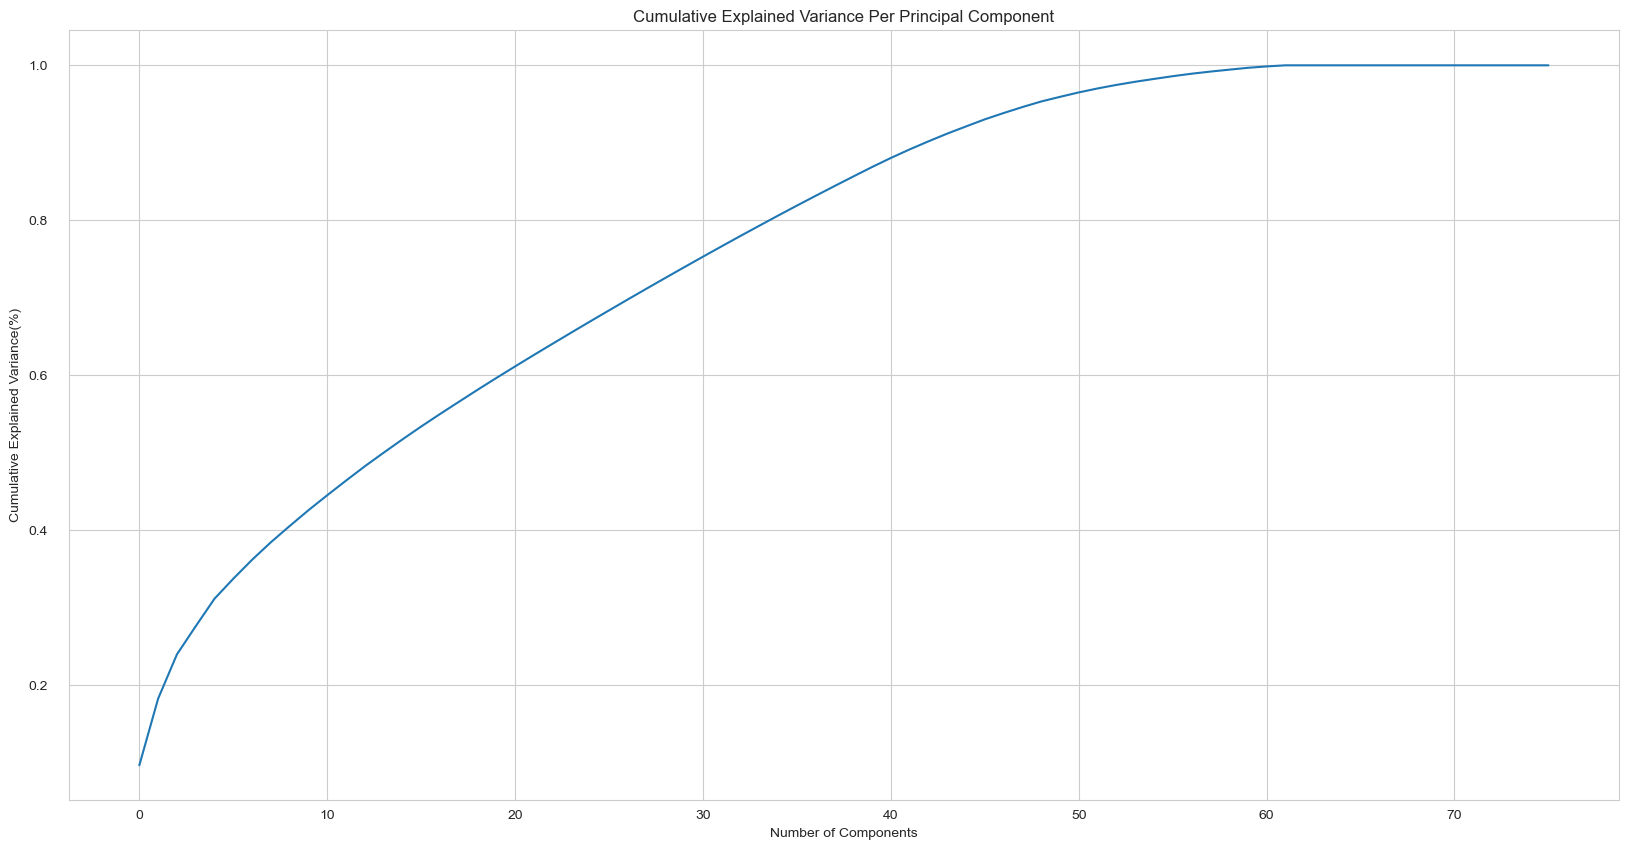

In [295]:
df = pca_plot(azdias_pers)

In [300]:
df[df.cum_vals > .6].head(5)

,idx,cum_vals
20,20,0.611419
21,21,0.626202
22,22,0.640756
23,23,0.655223
24,24,0.669553


25 components explain over 65% of the variance in the Person level

In [301]:
azdias_house.shape

(700564, 21)

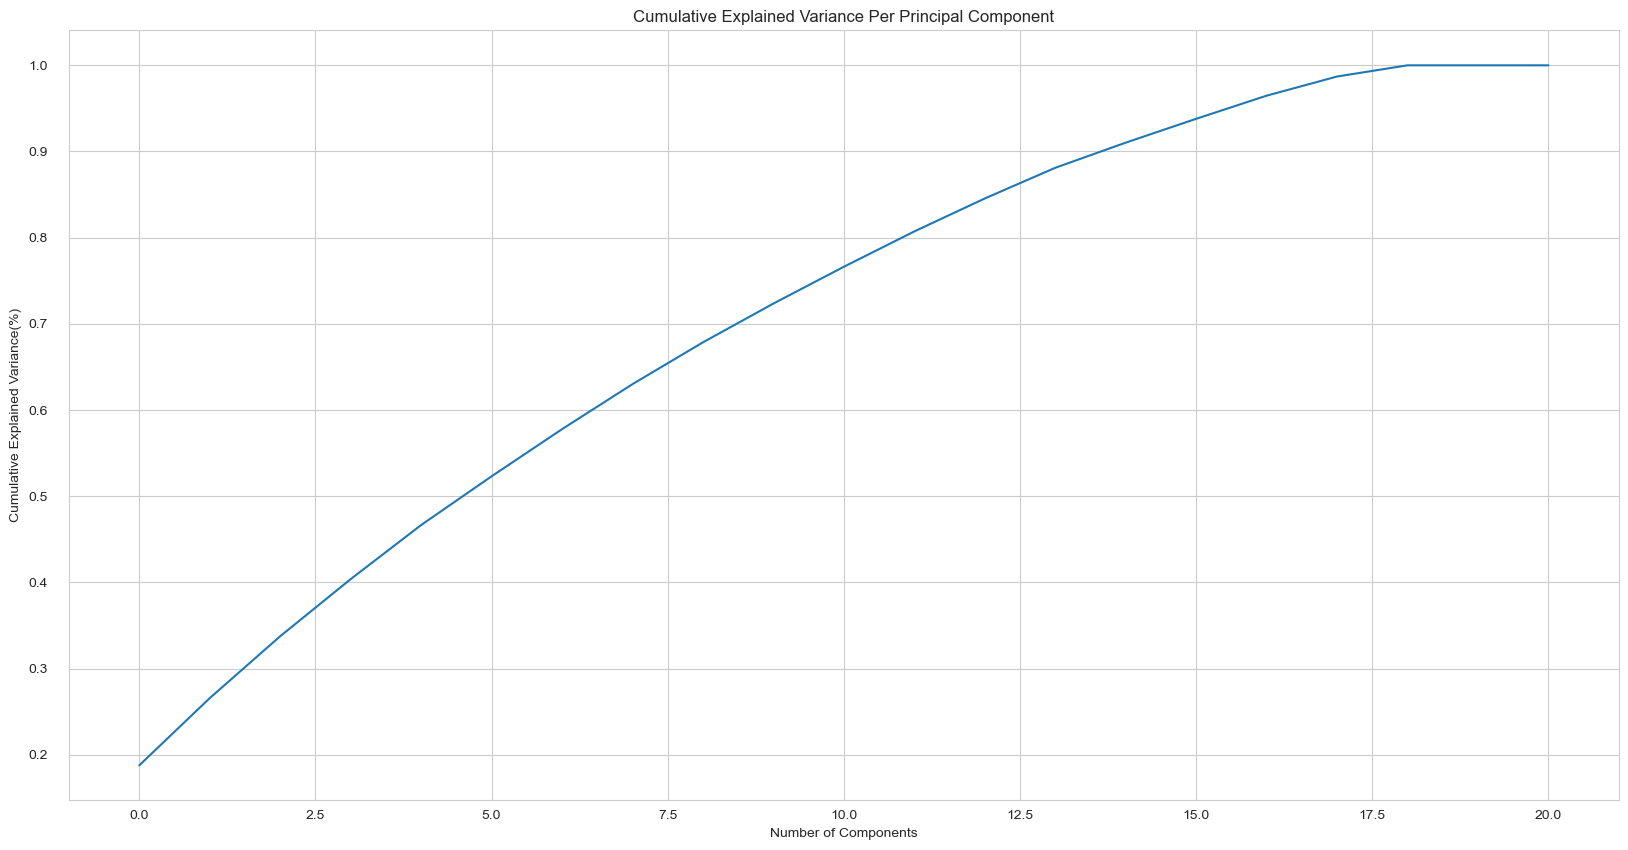

In [302]:
df = pca_plot(azdias_house)

In [304]:
df[df.cum_vals > .5].head(5)

,idx,cum_vals
5,5,0.523110
6,6,0.577846
7,7,0.630049
8,8,0.678588
9,9,0.723566


In the household level 5 components explains over 50% of the data variance

In [305]:
azdias_build.shape

(700564, 27)

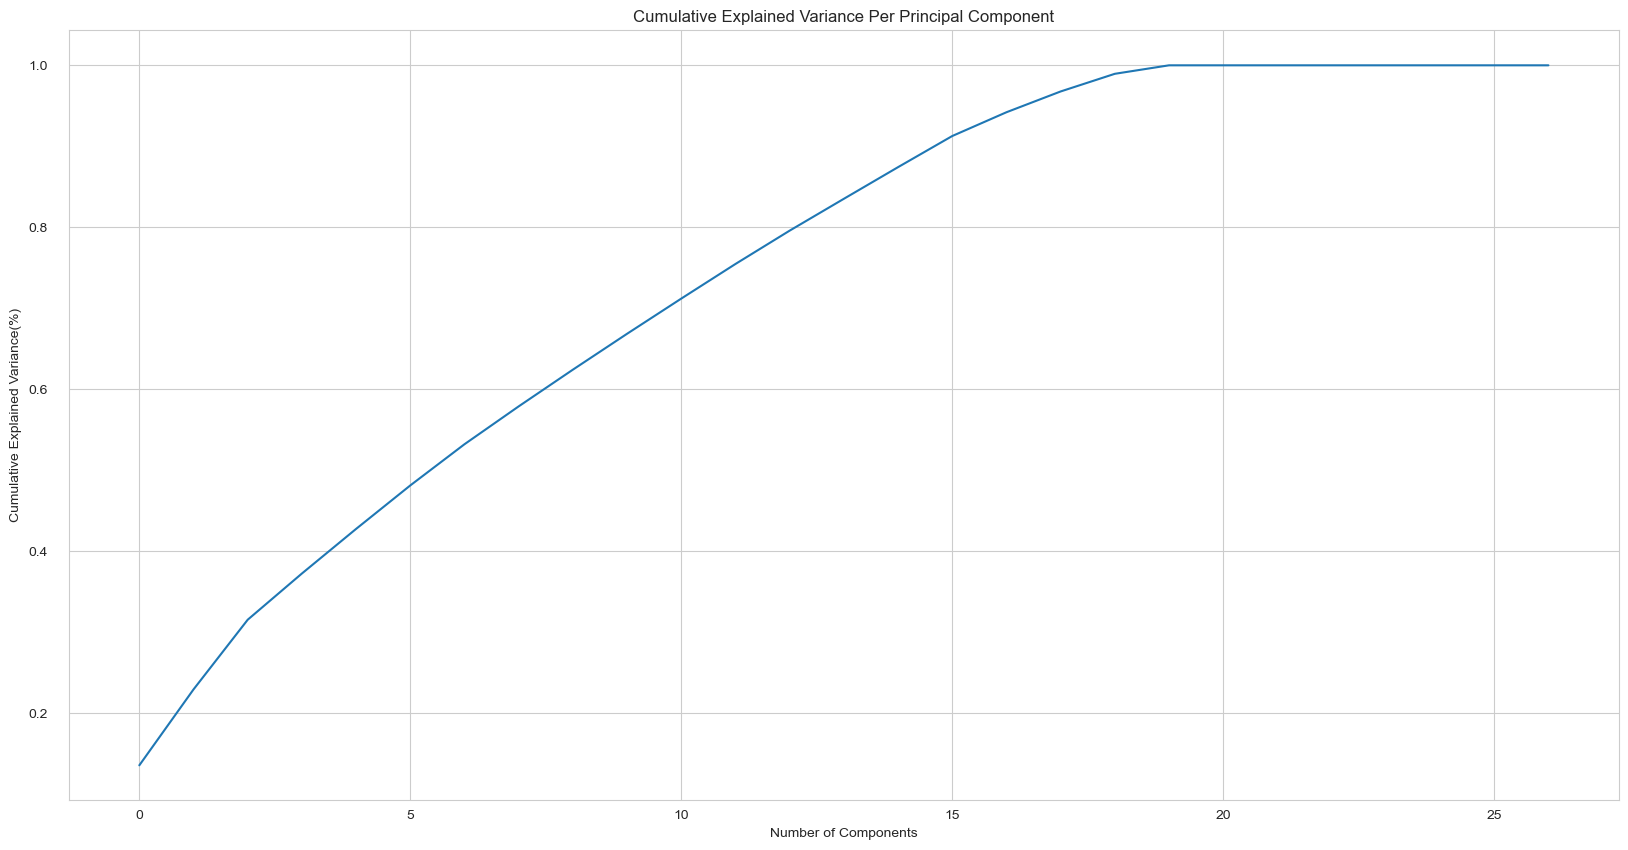

In [306]:
df = pca_plot(azdias_build)

In [307]:
df[df.cum_vals > .5].head(5)

,idx,cum_vals
6,6,0.531938
7,7,0.578702
8,8,0.624048
9,9,0.668389
10,10,0.711850


In the building level 6 components explains over 50% of the data variance

In [308]:
azdias_micro.shape

(700564, 50)

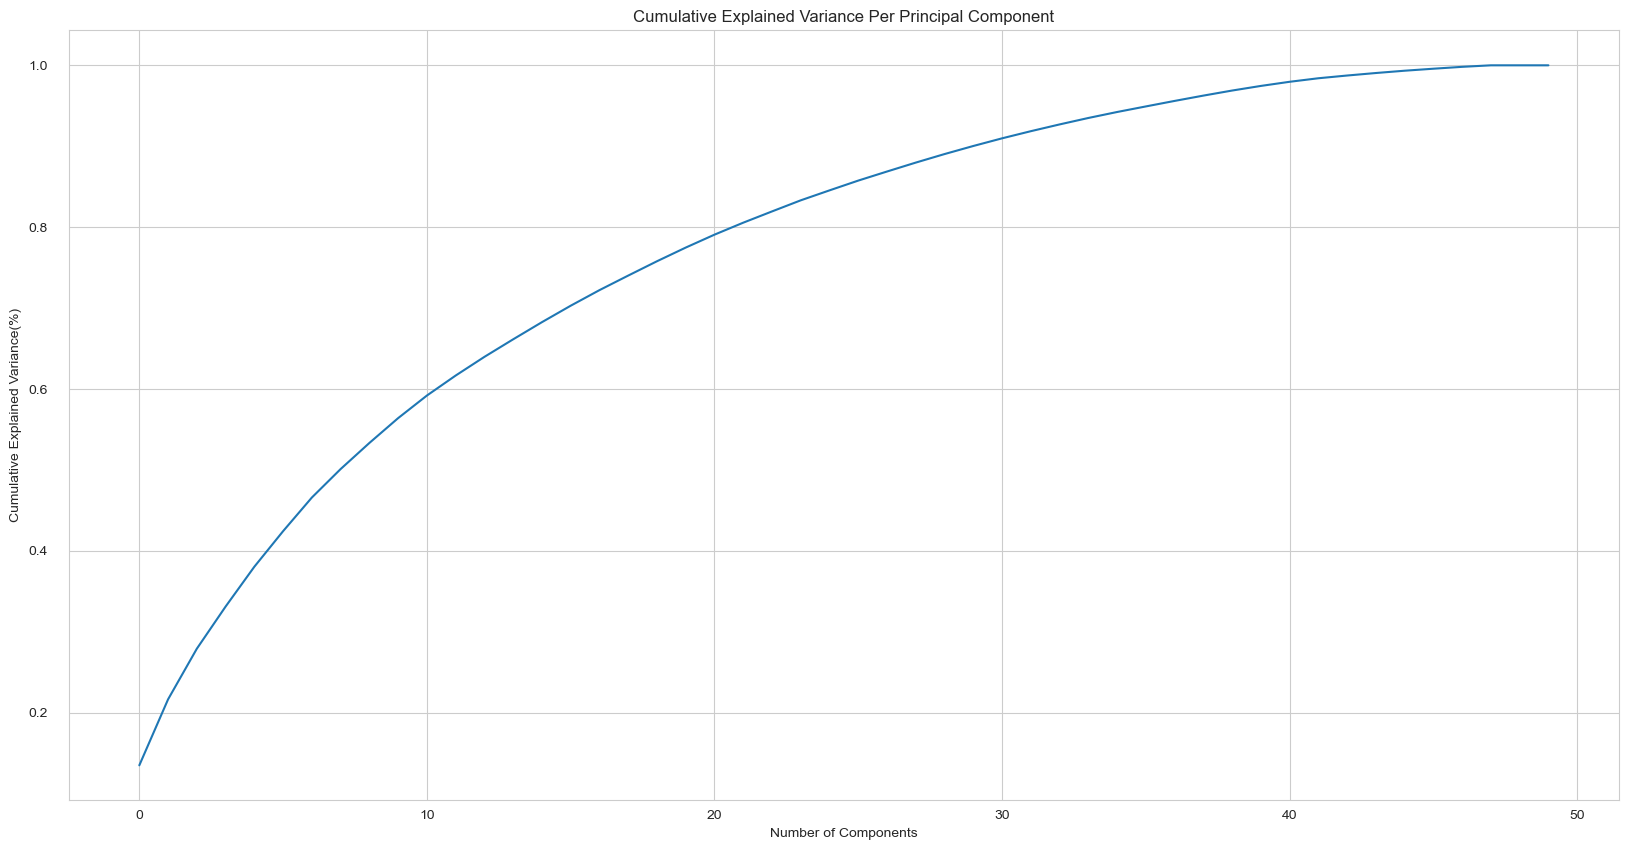

In [309]:
df = pca_plot(azdias_micro)

In [310]:
df[df.cum_vals > .5].head(5)

,idx,cum_vals
7,7,0.501106
8,8,0.533348
9,9,0.564043
10,10,0.591937
11,11,0.616645


In the Microcell level 8 components explains over 50% of the data variance

In [285]:
azdias_macro.shape

(700564, 84)

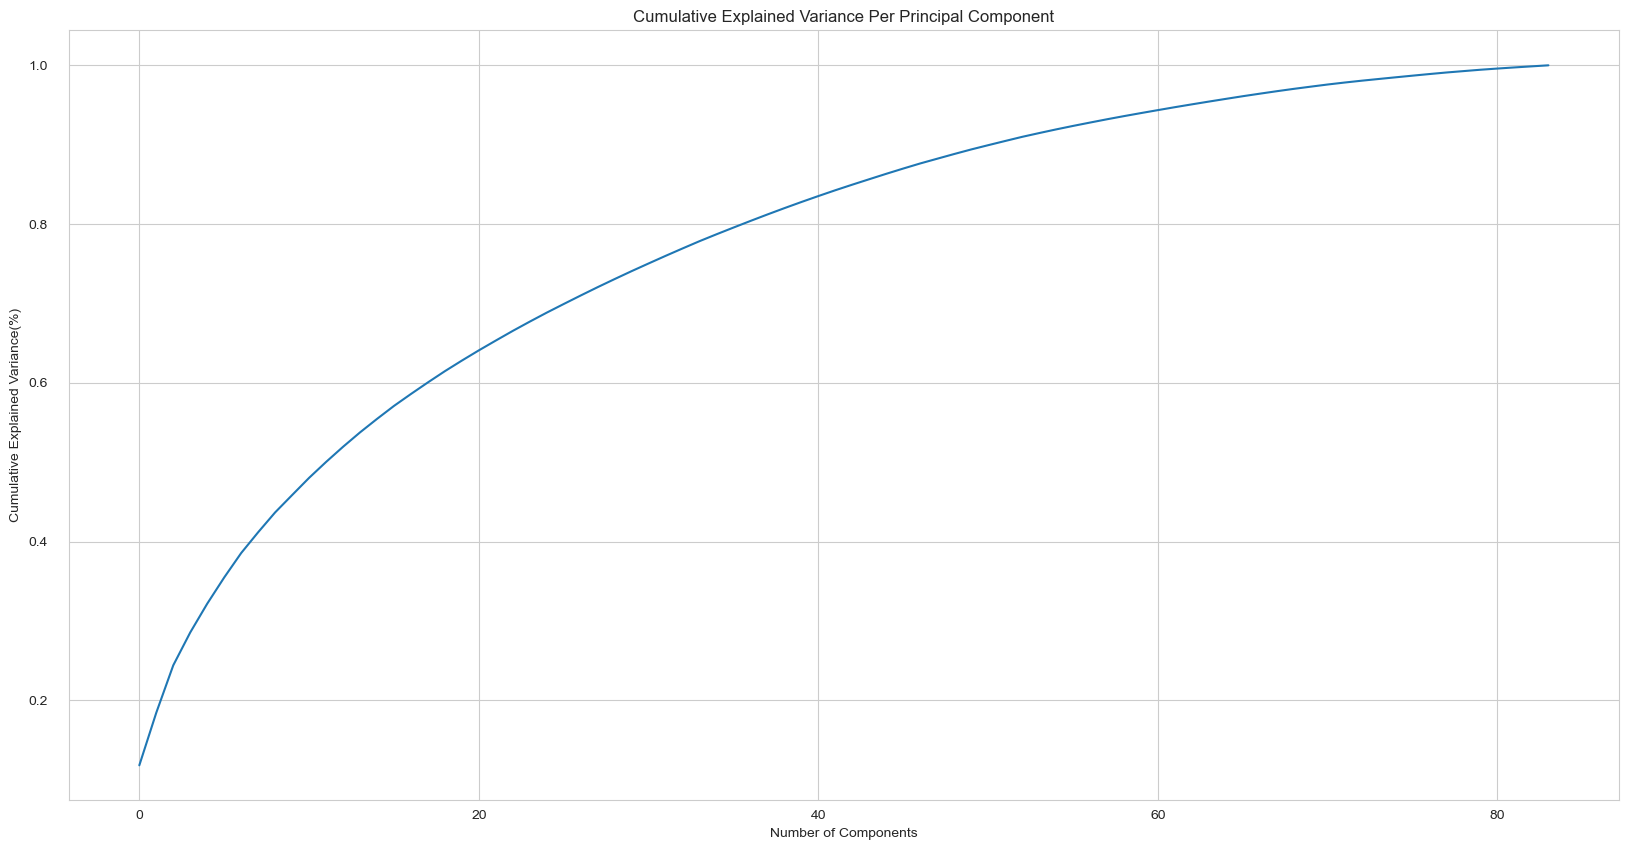

In [311]:
df = pca_plot(azdias_macro)

In [312]:
df[df.cum_vals > .5].head(5)

,idx,cum_vals
11,11,0.500232
12,12,0.519331
13,13,0.537474
14,14,0.554462
15,15,0.570836


In the Macrocell level 12 components explains over 50% of the data variance

In [339]:
person_comp = 25
house_comp = 5
build_comp = 6
micro_comp = 8
macro_comp = 12

## Perform Dimesionality Reduction

In [340]:
def pca(df, n_components = None, random_state = 102):
    """
    Function runs PCA
    Parameters: df - demographic data, n_components - number of components
    Output: pca - pca model, df_pca - pca data with reduced components
    """
    pca = PCA(n_components)
    df_pca = pca.fit_transform(df)
    return pca, df_pca
    

In [341]:
# Perform PCA on each information level features General Population, this is to reduce the data's dimensionality

azdias_pers_pca_model, azdias_pers_pca = pca(azdias_pers, person_comp)
azdias_house_pca_model, azdias_house_pca = pca(azdias_house, house_comp)
azdias_build_pca_model, azdias_build_pca = pca(azdias_build, build_comp)
azdias_micro_pca_model, azdias_micro_pca = pca(azdias_micro, micro_comp)
azdias_macro_pca_model, azdias_macro_pca = pca(azdias_macro, macro_comp)

In [342]:
# Perform PCA on each information level features Customers

customers_pers_pca = azdias_pers_pca_model.transform(customers_pers)
customers_house_pca = azdias_house_pca_model.transform(customers_house)
customers_build_pca = azdias_build_pca_model.transform(customers_build)
customers_micro_pca = azdias_micro_pca_model.transform(customers_micro)
customers_macro_pca = azdias_macro_pca_model.transform(customers_macro)

In [343]:
# Generate columns for full data set

person_cols = [f'person{i:02}'for i in range(1, person_comp + 1)]
house_cols = [f'house{i:02}'for i in range(1, house_comp + 1)]
build_cols = [f'build{i:02}'for i in range(1, build_comp + 1)]
micro_cols = [f'micro{i:02}'for i in range(1, micro_comp + 1)]
macro_cols = [f'macro{i:02}'for i in range(1, macro_comp + 1)]

In [344]:
#Recombine all PCA reduced General Population data into one dataframe

azdias_gen_pca = pd.concat([pd.DataFrame(azdias_pers_pca, columns = person_cols), 
                        pd.DataFrame(azdias_house_pca, columns = house_cols),
                        pd.DataFrame(azdias_build_pca, columns = build_cols),
                        pd.DataFrame(azdias_micro_pca, columns = micro_cols), 
                        pd.DataFrame(azdias_macro_pca, columns = macro_cols), 
                        azdias_com], axis = 1)

In [345]:
azdias_gen_pca.shape

(700564, 58)

In [319]:
#Recombine all PCA reduced Customer data into one dataframe

customers_gen_pca = pd.concat([pd.DataFrame(customers_pers_pca, columns = person_cols), 
                        pd.DataFrame(customers_house_pca, columns = house_cols),
                        pd.DataFrame(customers_build_pca, columns = build_cols),
                        pd.DataFrame(customers_micro_pca, columns = micro_cols), 
                        pd.DataFrame(customers_macro_pca, columns = macro_cols), 
                        customers_com], axis = 1)

In [320]:
def get_component_details(component, top = 3):
    '''
    Function the most important details related to the component.
    
    Parameters:
    component - number of the component to be analyzed;
    top - number of top features to return;
    '''
    #Get info_level ranges
    house_l, house_u = (person_comp, person_comp + house_comp)
    build_l, build_u = (person_comp + house_comp, person_comp + house_comp + build_comp)
    micro_l, micro_u = (person_comp + house_comp + build_comp, person_comp + house_comp + build_comp + micro_comp)
    macro_l, macro_u = (person_comp + house_comp + build_comp + micro_comp, 
                       person_comp + house_comp + build_comp + micro_comp + macro_comp)

    # Person component:
    if component in range(person_comp):
        print('\nPERSON Component:')
        print('-----------------')
        pca = azdias_pers_pca_model
        features = list(azdias_pers.columns)

    
    # Household component:
    elif component in range(house_l, house_u):
        print('\nHOUSEHOLD Component:')
        print('--------------------')
        pca = azdias_house_pca_model
        features = list(azdias_house.columns)
        component = component - person_comp
    
    # Building component:
    elif component in range(build_l, build_u):
        print('\nBUILDING Component:')
        print('--------------------')
        pca = azdias_build_pca_model
        features = list(azdias_build.columns)
        component = component - house_u 
    
    # Microcell component:   
    elif component in range(micro_l, micro_u):
        print('\nMICROCELL Component:')
        print('--------------------')
        pca = azdias_micro_pca_model
        features = list(azdias_micro.columns)
        component = component - build_u
    
    # Macrocell component:
    elif component in range(macro_l, macro_u):
        print('\nMACROCELL Component:')
        print('--------------------')
        pca = azdias_macro_pca_model
        features = list(azdias_macro.columns)
        component = component - micro_u
        
    else:
        return(print(f'Component out of range (0-{macro_u})'))
        
    
    # weights on the desired component:
    weights = list(pca.components_[component])
    
    # Get the index of ordered weights:
    ordered_idx = np.argsort(weights)[::-1]
    
    # Get top indexes:
    top_pos_idx = ordered_idx[:top]
    top_neg_idx = ordered_idx[-top:]
    
    # Print top positive weights on the component:
    print('Component {}'.format(component))
    print('------------')
    print('\n* Top {} Positive Weights *'.format(top))
    print('--------------------------')
    for i in top_pos_idx:

        print('{}: {:.3f}'.format(features[i], weights[i]))
    
    # Print top negative weights on the component:
    print('\n* Top {} Negative Weights *'.format(top))
    print('--------------------------')
    for j in top_neg_idx[::-1]:
        print('{}: {:.3f}'.format(features[j], weights[j]))

## Clustering Elbow Method

In [321]:
def elbow_method(df):
    
    """
    This function graphs the SSE for the range of n clusters
    Parameters: df - pca_reduced data components 
    Output: 
    """

    scores = []
    num_cluster = [n for n in range(2, 32, 4)]

    for n in num_cluster:
        kmeans = KMeans(n_clusters = n,  n_init = 'auto')
        kmeans.fit(df)
        scores.append(kmeans.inertia_)
    
    return num_cluster, scores
    
    

In [322]:
num_cluster, scores = elbow_method(azdias_gen_pca)

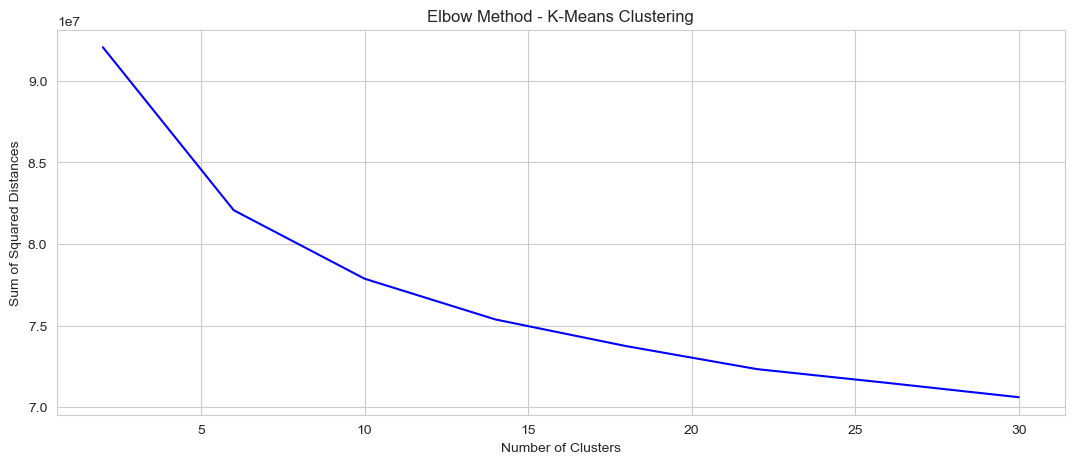

In [323]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (13, 5))

sns.lineplot(x = num_cluster, y = scores, 
             markers = True, color = 'blue').set(xlabel = 'Number of Clusters', 
                                                  ylabel = 'Sum of Squared Distances', 
                                                  title = "Elbow Method - K-Means Clustering")
sns.set_style(style = 'whitegrid')
plt.grid(True)

The optimal value of n clusters is usually where the plot has an elbow, which means the rate of decrease of the sum of squared distances slows down significantly. Based on your graph, it seems that the elbow is at around 15 clusters, so we will choose that as our n value

## Clustering Modeling

In [325]:
def kmeans(df):
    """
    Function models using Kmeans to cluster data
    Parameters: pca df, reduced
    Output - kmeans - predicted clusters, km - model
    """
    
    kmeans = KMeans(n_clusters = 15, n_init = 'auto', random_state = 102)
    km = kmeans.fit_predict(df)
    
    return kmeans, km
    

In [326]:
#Model and Predict on General Population and Customers Kmeans

azdias_km_model, azdias_km = kmeans(azdias_gen_pca)
customers_km = azdias_km_model.predict(customers_gen_pca)

In [327]:
# Format Data to compare General Population to Customer population

customer_clusters = pd.Series(customers_km)
population_clusters = pd.Series(azdias_km)
cc = customer_clusters.value_counts().sort_index()
pc = population_clusters.value_counts().sort_index()
total_pop = np.sum(pc)
total_cust = np.sum(cc)
cluster_df = pd.DataFrame(columns = ['general_population', 'customers'])
cluster_df['general_population'] = [(count / total_pop) * 100 for count in pc]
cluster_df['customers'] = [(count / total_cust) * 100 for count in cc]
cluster_df['Cluster'] = cluster_df.index.values

melted_df = pd.melt(cluster_df, id_vars = ['Cluster'] , value_vars = ['general_population', 'customers'], \
                    var_name = 'Group', value_name ='Percentage')

C:\Users\e079666\AppData\Local\Temp\ipykernel_10012\3346207944.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


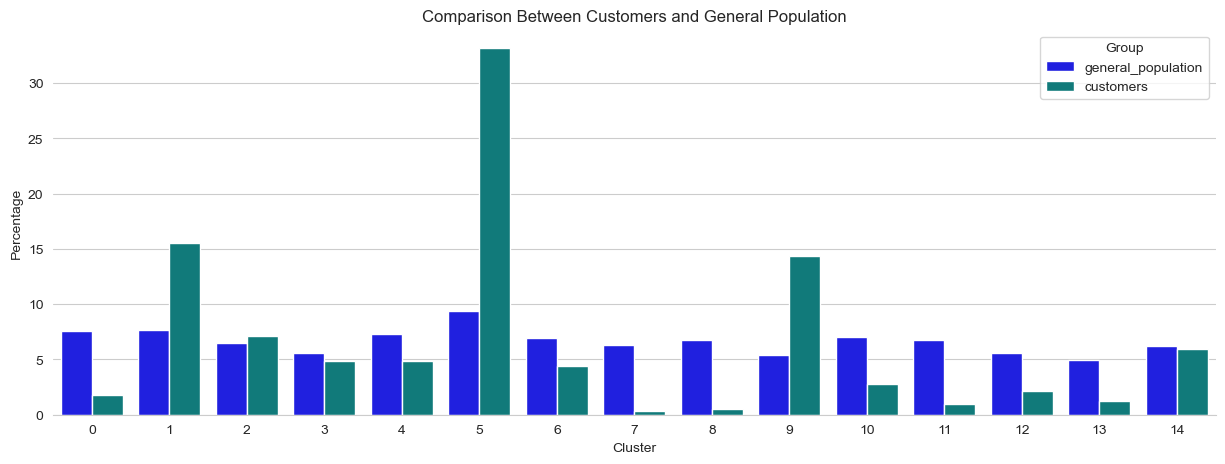

In [328]:
# Plot bar graph comparing General Population Percent to Customer Population Percent

colors = {'customers': 'darkcyan', 'general_population': 'blue'}

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 5))
sns.barplot(x = 'Cluster', y = 'Percentage', hue = 'Group', data = melted_df, palette = colors, ax = ax).set(
    title = 'Comparison Between Customers and General Population')
sns.despine(left=True, top = True)
fig.show()

In [329]:
# Find percent Difference between General Population and Customers to see which clusters are unevenly represented by Customers

percent_diff = [((cluster_df.customers[i] - cluster_df.general_population[i]) / cluster_df.general_population[i]) * 100 for i in range(cluster_df.shape[0])]
ordered_index = np.argsort(percent_diff)[::-1]
percent_diff.sort(reverse = True)
df_stats = pd.DataFrame({'Cluster':ordered_index, 'Percent Diff':percent_diff})

In [330]:
top_5_over = df_stats[:5]
top_5_over

,Cluster,Percent Diff
0,5,252.335197
1,9,167.509978
2,1,102.260252
3,2,9.431490
4,14,-4.311635


In [331]:
top_5_under = df_stats[-5:]
top_5_under

,Cluster,Percent Diff
10,13,-75.836250
11,0,-76.857519
12,11,-85.173797
13,8,-92.399584
14,7,-94.504657


We are interested in clusters where the customers is higher than general population. Looks like Cluster 2 containing the largest percent difference from customers to general population, Cluster 3 and 8 subsequetly follow. These demographic groups are potenial areas to focus our marketing campaigns on

In [332]:
def cluster_get_important_info(cluster, kmeans = azdias_km_model, top_comp = 3):
    
    """
    Gets the most closely distanced cluster points and returns the 
    components associated with those points 
    and the feature weights associated with those components and prints them
    
    Parameters:
    cluster - cluster we eval, kmeans - kmeans fitted model, top_comp - number of components to display
    
    
    """
    
    # Getting cluster center:
    cluster_centers = kmeans.cluster_centers_[cluster]
    
    # Getting more important components:
    pos_idx = np.argsort(cluster_centers)[::-1]
    pos_idx = pos_idx[:top_comp]
    
    print(f'CLUSTER {cluster}')
    
    for comp in pos_idx:
        get_component_details(comp)


In [333]:
cluster_get_important_info(top_5_over['Cluster'].iloc[0], top_comp = 3)

CLUSTER 5

PERSON Component:
-----------------
Component 2
------------

* Top 3 Positive Weights *
--------------------------
MOVEMENT_MA: 0.335
GREEN_AVANTGARDE_1: 0.335
LP_STATUS_GROB_5.0: 0.282

* Top 3 Negative Weights *
--------------------------
GREEN_AVANTGARDE_0: -0.335
LP_STATUS_GROB_1.0: -0.209
FINANZ_HAUSBAUER: -0.203

PERSON Component:
-----------------
Component 1
------------

* Top 3 Positive Weights *
--------------------------
ANREDE_KZ_1.0: 0.319
SEMIO_VERT: 0.318
FINANZ_MINIMALIST: 0.258

* Top 3 Negative Weights *
--------------------------
ANREDE_KZ_2.0: -0.319
SEMIO_DOM: -0.273
SEMIO_KRIT: -0.248

MICROCELL Component:
--------------------
Component 0
------------

* Top 3 Positive Weights *
--------------------------
KBA05_MOTOR: 0.286
KBA05_KW3: 0.264
KBA05_MOD1: 0.248

* Top 3 Negative Weights *
--------------------------
KBA05_KW1: -0.260
KBA05_CCM1: -0.244
KBA05_SEG6_0.0: -0.166


This cluster 5 is most representative of `Component 1 and 2 from Person` and `Component 0 from Microcell`
- `Component 2 Person` consists of people that were dominated by mainstream youth movements, average earners, and dominating youth movement enviornmental sustainability 
- `Component 1 Person` consists of males, that have high financial interest, that are practical and pragmatic 
- `Component 0 Microcell` has large engines in Microcell, engine power a lot higher than 119kW, and large number of upper-class cars.

Appears Cluster 6 represents males that a practical, that like cars, and are average to above average earners

In [334]:
pd.set_option('max_colwidth', 1000)

In [359]:
attribute_values[attribute_values['Attribute'] == 'KBA13_KW_121']

,Attribute,Description,Value,Meaning
1650,KBA13_KW_121,share of cars with an engine power more than 120 KW - PLZ8,-1,unknown
1651,KBA13_KW_121,share of cars with an engine power more than 120 KW - PLZ8,0,none
1652,KBA13_KW_121,share of cars with an engine power more than 120 KW - PLZ8,1,very low
1653,KBA13_KW_121,share of cars with an engine power more than 120 KW - PLZ8,2,low
1654,KBA13_KW_121,share of cars with an engine power more than 120 KW - PLZ8,3,average
1655,KBA13_KW_121,share of cars with an engine power more than 120 KW - PLZ8,4,high
1656,KBA13_KW_121,share of cars with an engine power more than 120 KW - PLZ8,5,very high


In [336]:
cluster_get_important_info(top_5_over['Cluster'].iloc[1], top_comp = 3)

CLUSTER 9

MACROCELL Component:
--------------------
Component 0
------------

* Top 3 Positive Weights *
--------------------------
KBA13_HERST_BMW_BENZ: 0.229
KBA13_SEG_OBEREMITTELKLASSE: 0.195
KBA13_KW_121: 0.175

* Top 3 Negative Weights *
--------------------------
KBA13_KMH_180: -0.195
KBA13_SEG_KLEINWAGEN: -0.190
KBA13_SITZE_5: -0.187

MICROCELL Component:
--------------------
Component 0
------------

* Top 3 Positive Weights *
--------------------------
KBA05_MOTOR: 0.286
KBA05_KW3: 0.264
KBA05_MOD1: 0.248

* Top 3 Negative Weights *
--------------------------
KBA05_KW1: -0.260
KBA05_CCM1: -0.244
KBA05_SEG6_0.0: -0.166

PERSON Component:
-----------------
Component 2
------------

* Top 3 Positive Weights *
--------------------------
MOVEMENT_MA: 0.335
GREEN_AVANTGARDE_1: 0.335
LP_STATUS_GROB_5.0: 0.282

* Top 3 Negative Weights *
--------------------------
GREEN_AVANTGARDE_0: -0.335
LP_STATUS_GROB_1.0: -0.209
FINANZ_HAUSBAUER: -0.203


Cluster 11 consists of 3 main components, Component 0 form Macro-cell, Component 0 from Microcell, and Component 2 from Person.
- Component 0 Macro-cell: high number of BMWs and Mercedes, cars with high engine power, and middle to upper class cars in Macro cell
- Component 0 Microcell: has large engines in Microcell, engine power a lot higher than 119kW, and large number of upper classes cars.
- Component 2 Person: consists of people that were dominated by mainstream youth movements, average earners, and dominating youth movement environmental sustainability.

In [366]:
attribute_values[attribute_values['Attribute'] == 'KBA13_HALTER_35']

,Attribute,Description,Value,Meaning
1371,KBA13_HALTER_35,share of car owners between 31 and 35 within the PLZ8,-1,unknown
1372,KBA13_HALTER_35,share of car owners between 31 and 35 within the PLZ8,0,none
1373,KBA13_HALTER_35,share of car owners between 31 and 35 within the PLZ8,1,very low
1374,KBA13_HALTER_35,share of car owners between 31 and 35 within the PLZ8,2,low
1375,KBA13_HALTER_35,share of car owners between 31 and 35 within the PLZ8,3,average
1376,KBA13_HALTER_35,share of car owners between 31 and 35 within the PLZ8,4,high
1377,KBA13_HALTER_35,share of car owners between 31 and 35 within the PLZ8,5,very high


In [338]:
cluster_get_important_info(top_5_under['Cluster'].iloc[0], top_comp = 3)

CLUSTER 13

MACROCELL Component:
--------------------
Component 1
------------

* Top 3 Positive Weights *
--------------------------
KBA13_BJ_2000: 0.217
PLZ8_ANTG4: 0.190
PLZ8_ANTG2: 0.183

* Top 3 Negative Weights *
--------------------------
KBA13_KW_61_120: -0.225
KBA13_SITZE_5: -0.204
KBA13_HALTER_20: -0.187

MACROCELL Component:
--------------------
Component 2
------------

* Top 3 Positive Weights *
--------------------------
PLZ8_ANTG4: 0.258
KBA13_HALTER_35: 0.198
PLZ8_ANTG2: 0.166

* Top 3 Negative Weights *
--------------------------
KBA13_AUTOQUOTE: -0.307
KBA13_HALTER_50: -0.244
KBA13_SITZE_6: -0.221

PERSON Component:
-----------------
Component 0
------------

* Top 3 Positive Weights *
--------------------------
SEMIO_REL: 0.304
SEMIO_TRADV: 0.254
SEMIO_FAM: 0.249

* Top 3 Negative Weights *
--------------------------
SEMIO_ERL: -0.277
ZABEOTYP_3.0: -0.227
SEMIO_LUST: -0.198


Cluster 13 is most repesented by Component 1 from Macrocell, Component 2 from Macrocell, and Component 0 from Person
- `Component 1 Macrocell`: high share of people living in multi family homes and apartments /  apartments and cars between 2001 2003 (older cars)
- `Component 0 Person` consists of not religious, not traditional, and well aquainted with people
- `Component 2 Macrocell:` large share of car owners age 31-35, high share of people living in multi family homes and apartments

In conclusion, we shoudl focus marketing to men that are average to above average earners that enjoy luxury and upper class cars. While we should avoid marketing to people that are younger car owners and want newer cars.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [367]:
def transform_data(df, cols = None, scaler = None):
    
    """
    this function dummies and scales data inputed
    
    Parameters: df - demographic data
    Output df - scaled and dummied demographic data
    """
    
    df = dummy(df)
    
    if cols is not None:
        missing_dummy = cols.difference(df.columns)

        if len(missing_dummy) > 0:
            df[missing_dummy] = 0
            df = df[cols]

    if scaler == None:
        
        cols, scaler = scale(df)
        df = transform_scale(df, cols, scaler)
        
        return df
    
    else:
        
        df = transform_scale(df, cols, scaler)
    
        return df

In [392]:
def data_clean(df, test = False, columns_drop = None):
    
    """
    Function cleans the data to prepare for machine learning
    Parameters:
    df - demographic, unclean data
    test - test set or mot
    columns_drop - columns to drop from test if it is test data
    
    Output: df - cleaned df ready for ML
    
    """
    
    
    unknown_dict = {}
    all_columns = list()

    for i, row in attribute_values.iterrows():
        if "unknown" in str(row['Meaning']).lower():
            unknown_dict[row['Attribute']] = [int(num) for num in str(row['Value']).split(', ')]

    unknown_dict['AGER_TYP'].append(0)
    unknown_dict['AGER_TYP'] = list(set(unknown_dict['AGER_TYP']))
    unknown_dict['ALTERSKATEGORIE_GROB'].append(9)
    unknown_dict['ALTERSKATEGORIE_GROB'] = list(set(unknown_dict['ALTERSKATEGORIE_GROB']))


    # these repersent birth years that are equal to zero and should be nan
    incorrect_values = {'KBA05_MODTEMP': [6.0], 'LP_FAMILIE_FEIN': [0.0], 'LP_FAMILIE_GROB': [0.0],
                                'LP_LEBENSPHASE_FEIN': [0.0], 'LP_LEBENSPHASE_GROB': [0.0], 'ORTSGR_KLS9': [0.0], 'GEBURTSJAHR': [0]}



    category_columns = ['CJT_GESAMTTYP', 'D19_KONSUMTYP',
     'FINANZTYP',
     'GEBAEUDETYP',
     'GFK_URLAUBERTYP',
     'HEALTH_TYP',
     'KBA05_MAXHERST',
     'NATIONALITAET_KZ',
     'RETOURTYP_BK_S',
     'SHOPPER_TYP',
     'WOHNLAGE',
     'ZABEOTYP', 'LP_FAMILIE_GROB',
      'OST_WEST_KZ', 'REGIOTYP', 'KBA05_SEG6', 
        'KBA05_MODTEMP', 'KBA05_HERSTTEMP', 'LP_STATUS_GROB', 'VERS_TYP', 'ANREDE_KZ', 'GREEN_AVANTGARDE']
    
    if test:

        replace_unknown_w_nan(df, unknown_dict)
        replace_unknown_w_nan(df, incorrect_values)
        df = feature_engineering(df)[0]
        df.drop(columns_drop, axis = 1, inplace =True)
        df = change_dtypes(df)
        df = transform_data(df)
        return df

    else:
        replace_unknown_w_nan(df, unknown_dict)
        replace_unknown_w_nan(df, incorrect_values)

        df, cols_drop = drop_useless_cols(df)
        all_columns += cols_drop

        df, cols_drop = drop_columns_missing_data(df, threshold = .30)
        all_columns += cols_drop

        df = fix_mixed_types(df)
        df = feature_engineering(df)[0]

        cols_drop, corr = analyze_correlation(df, category_columns, method = 'pearson', corr_threshold = .8)
        df.drop(cols_drop, axis = 1, inplace = True)
        all_columns += cols_drop

        df = change_dtypes(df)
        df = transform_data(df)


        return df, all_columns


In [374]:
def plot_learning_curves(X, y, model, steps):
    '''
    It plots the learning curve for the desired algorithm.
    
    Parameters:
    X - predictive features; y: response, model - instantiated ojectused to train
    steps - integer defining the steps for training size.
    '''
    # Setting train_sizes:
    train_sizes = np.linspace(0.1, 1.0, steps)
    
    # Applying sklearn learning_curve:
    train_size, train_score, test_score = learning_curve(model, X, y, 
                                                         scoring = 'roc_auc', 
                                                         train_sizes = train_sizes)
    # Computing average train and test scores:
    avg_train_score = np.mean(train_score, axis = 1)
    avg_test_score = np.mean(test_score, axis = 1)
    
    # Printing results:
    print("ROC_AUC train score: {:.2f}".format(avg_train_score[-1]))
    print("ROC_AUC valid. score: {:.2f}".format(avg_test_score[-1]))
    
    # Creating learning curve plot:
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 5))

    sns.lineplot(x = train_sizes * 100, y = avg_train_score, 
                 marker = 'o', color = 'darkcyan', 
                 label = 'Train', ax = ax).set(xlabel = 'Training Set Percentage', 
                                               ylabel = 'Model Score', 
                                               title = 'Learning Curve')

    sns.lineplot(x = train_sizes * 100, y = avg_test_score, 
                 marker = 'o', color = 'red', 
                 label = 'Validation', ax = ax)

    sns.despine(left=True, top = True)

    fig.show()

In [375]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

C:\Users\e079666\AppData\Local\Temp\ipykernel_10012\3492614913.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


In [376]:
# Seperate train data 

X = mailout_train.drop('RESPONSE',axis=1)
y = mailout_train['RESPONSE']

In [377]:
# Clean train data set
X_clean, columns_drop = data_clean(X)
mailout_train_clean = pd.concat([X_clean, y], axis = 1)

There are 11 columns missing more than 30.0% of data
These columns were dropped ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']


In [378]:
rand_df = mailout_train_clean.sample(frac = 1).reset_index(drop = True) #randomize dataframe order
rand_y = rand_df['RESPONSE']
rand_X = rand_df.drop('RESPONSE', axis = 1)

ROC_AUC train score: 0.99
ROC_AUC valid. score: 0.68


C:\Users\e079666\AppData\Local\Temp\ipykernel_10012\934454229.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


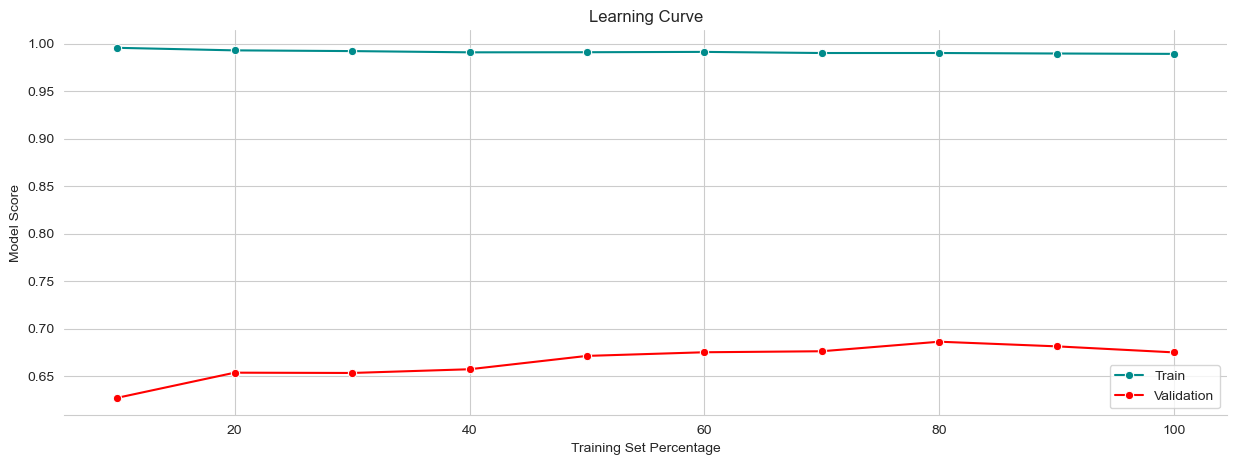

In [379]:
# Learning Curve XGB Classfier

model_xgb = xgb.XGBClassifier()
plot_learning_curves(rand_X, rand_y, model_xgb, 10)

Appears to be overfitting on the data, no trend towards eachother 

ROC_AUC train score: 0.91
ROC_AUC valid. score: 0.75


C:\Users\e079666\AppData\Local\Temp\ipykernel_10012\934454229.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


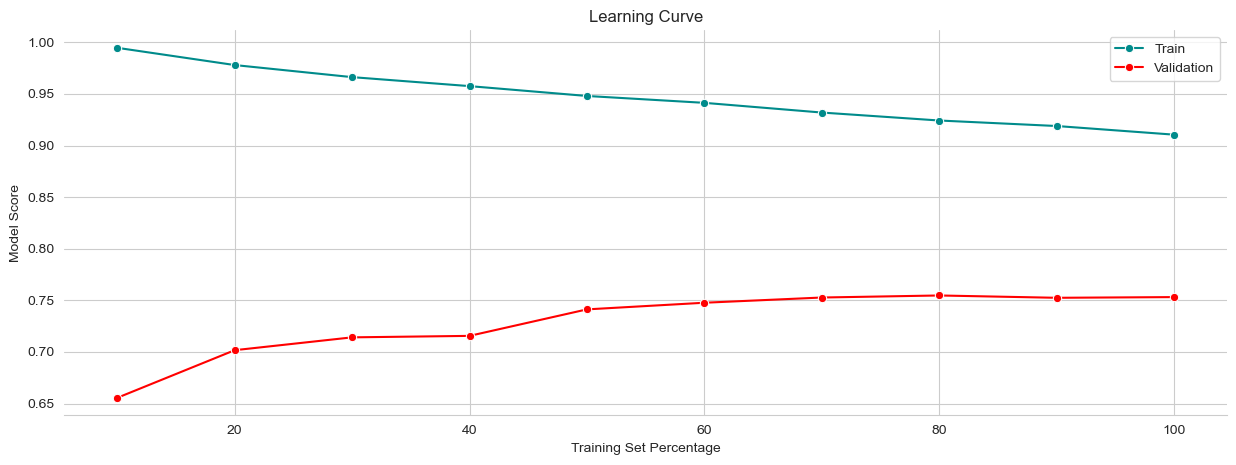

In [380]:
model = GradientBoostingClassifier()
plot_learning_curves(rand_X, rand_y, model, 10)

Appears to be fitting with a good score

ROC_AUC train score: 0.83
ROC_AUC valid. score: 0.74


C:\Users\e079666\AppData\Local\Temp\ipykernel_10012\934454229.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


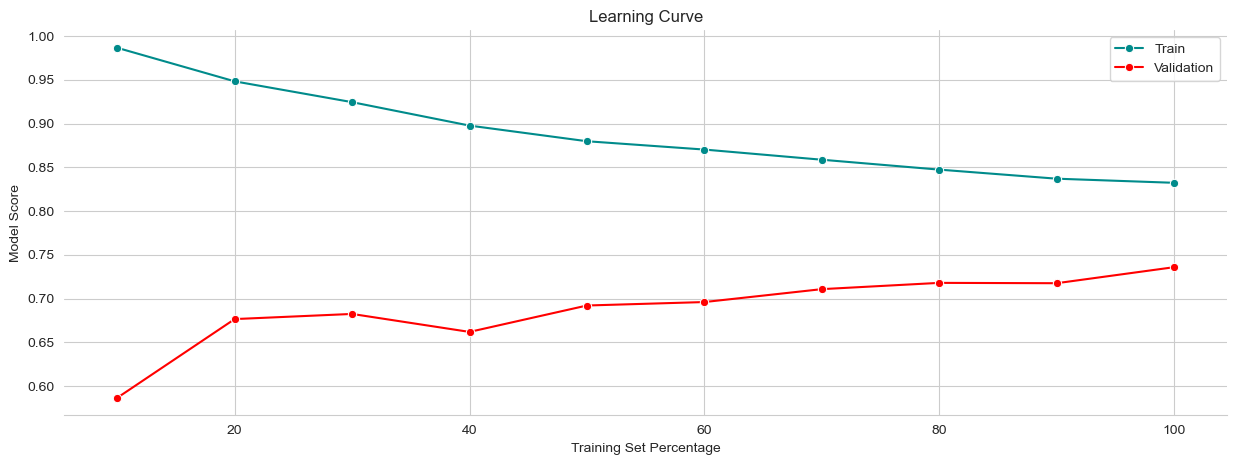

In [381]:
model = AdaBoostClassifier()
plot_learning_curves(rand_X, rand_y, model, 10)

Appears to be fitting with a lesser score

## Training Classifier

This step we will fine tune our model and find best combo of parameters

In [382]:
# Model the data then test for the best parameters to improve fitting score

model = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 220, random_state = 101)


params = {'min_samples_split': [2, 4], 
          'max_depth': [3, 5], 
          'n_estimators': [100, 200]}

cv = GridSearchCV(model, param_grid = params, scoring = 'roc_auc')

cv.fit(X_clean, y)

GridSearchCV(estimator=GradientBoostingClassifier(n_estimators=220,
                                                  random_state=101),
             param_grid={'max_depth': [3, 5], 'min_samples_split': [2, 4],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

In [383]:
cv.best_params_

{'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}

In [384]:
cv.best_score_

0.7517265110337842

## Test Classifier

In [393]:
# Read in test data

mailout_test = pd.read_csv('Udacity_test.csv')

C:\Users\e079666\AppData\Local\Temp\ipykernel_10012\3516562472.py:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv('Udacity_test.csv')


In [394]:
lnr = mailout_test['LNR'].to_list()

In [395]:
# Cleam, scale, and onehot encode test data

mailout_test = data_clean(mailout_test, test = True, columns_drop = columns_drop)

In [396]:
# Get predictions using tuned model on test data

y_pred = cv.predict(mailout_test)

In [397]:
y_pred = pd.Series(y_pred)